In [21]:
import numpy as np
import hydra
import torch
import pickle
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from pytorch_lightning import (
    LightningDataModule,
    seed_everything,
)

import yaml
import umap
from sklearn.decomposition import PCA

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from tqdm import tqdm

from utils import *
from multimodal_contrastive.utils import utils
from gflownet.config import Config, init_from_dict
from gflownet.data.data_source import DataSource
from gflownet.tasks.morph_frag import MorphSimilarityTrainer
from gflownet.envs.frag_mol_env import FragMolBuildingEnvContext, _recursive_decompose

# register custom resolvers if not already registered
OmegaConf.register_new_resolver("sum", lambda input_list: np.sum(input_list), replace=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Sample trajectories using the trained GflowNet

In [3]:
def load_trainer(run_dir):
    # Setup path to saved run configuration
    with open(run_dir + "/config.yaml", "r") as f:
        run_config = yaml.load(f, Loader=yaml.FullLoader)

    config = init_from_dict(Config(), run_config)
    config.log_dir = "/home/mila/s/stephen.lu/scratch/gfn_gene/sampling_logs"
    config.overwrite_existing_exp = True

    # Load gflownet model trainer setup for sampling
    trainer = MorphSimilarityTrainer(config)

    model_state = torch.load(f'{run_dir}/model_state.pt')
    trainer.model.load_state_dict(model_state['models_state_dict'][0])
    trainer.model = trainer.model.cuda()
    
    return trainer

def sample_from_trained_model(run_dir, n_samples, n_samples_per_iter = 64, trainer=None):
    if trainer is None:
        trainer = load_trainer(run_dir)

    # Sample trajectories using the trained model
    n_iterations = n_samples // n_samples_per_iter
    src = DataSource(trainer.cfg, trainer.ctx, trainer.algo, trainer.task, replay_buffer=None)

    samples = []

    with torch.no_grad():
        for t in range(n_iterations):
            p = 0.01
            cond_info = trainer.task.sample_conditional_information(n_samples_per_iter, t)
            trajs = trainer.algo.create_training_data_from_own_samples(trainer.model, n_samples_per_iter, cond_info["encoding"], p)
            src.set_traj_cond_info(trajs, cond_info)
            src.compute_properties(trajs, mark_as_online=True)
            src.compute_log_rewards(trajs)
            
            for traj in trajs:
                if traj['mol'] is None:
                    continue
                mol = traj['mol']
                reward = traj['flat_rewards']
                samples.append((mol, reward))

    return samples
        

## Load PUMA dataset and obtain representations

In [4]:
# Load config for CLIP model
config_name = "puma_sm_gmc"
configs_path = "../../configs"

with hydra.initialize(version_base=None, config_path=configs_path):
    cfg = hydra.compose(config_name=config_name)

print(cfg.datamodule.split_type)

# Set seed for random number generators in pytorch, numpy and python.random
# and especially for generating the same data splits for the test set
if cfg.get("seed"):
    seed_everything(cfg.seed, workers=True)

# Load test data split
datamodule: LightningDataModule = hydra.utils.instantiate(cfg.datamodule)
datamodule.setup("test")

shuffled_scaffold


Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


Train on samples from shuffled_scaffold.
Train on 13582 samples.
Validate on 1698 samples.
Test on 1698 samples.


In [5]:
base_dir = "/home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps"

In [6]:
# Load model from checkpoint
ckpt_path = "/home/mila/s/stephen.lu/gfn_gene/res/mmc/models/morph_struct_90_step_val_loss.ckpt"
model = utils.instantiate_model(cfg)
model = model.load_from_checkpoint(ckpt_path, map_location=device)
model = model.eval()

# Get latent representations for full dataset
representations = model.compute_representation_dataloader(
    make_eval_data_loader(datamodule.dataset),
    device=device,
    return_mol=False
)

INFO:root:Instantiating torch.nn.module JointEncoder
INFO:root:Instantiating lightning model <multimodal_contrastive.networks.models.GMC_PL>
/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'encoder_joint' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_joint'])`.
  rank_zero_warn(
/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'common_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['common_encoder'])`.
  rank_zero_warn(
100%|██████████| 133/133 [01:41<00:00,  1.31it/s]


## Plot reward distribution of trajectories sampled from the final trained models versus the reward distribution of the background dataset

In [ ]:
trainer = load_trainer(base_dir + "/04-12-03-58-morph-sim-target-67-algo/absurd-sweep-2-id-6gjx9a58")
dataset_rewards = (cosine_similarity(representations['struct'], trainer.task.target) + 1) / 2
rnd_idx = np.random.choice(len(dataset_rewards), 1000, replace=False)
dataset_rewards_subset = dataset_rewards[rnd_idx]

In [ ]:
models = {
    "GFN": "04-11-20-00-morph-sim-target-25-temp/pleasant-sweep-8-id-zsqa420a",
    "RND": "04-11-15-28-morph-sim-target-25-algo/crimson-sweep-4-id-s5qy4aa5",
    "A2C": "04-11-15-28-morph-sim-target-25-algo/desert-sweep-3-id-rzf482zv",
    "SQL": "04-11-15-28-morph-sim-target-25-algo/vague-sweep-2-id-jl57kuml",
}

n_samples = 1000
for model_name, run_id in models.items():
    run_dir = f"{base_dir}/{run_id}"
    samples = sample_from_trained_model(run_dir, n_samples, n_samples)
    rewards = [reward.item() for _, reward in samples]
    
    plt.hist(rewards, bins=50, alpha=0.5, label=model_name)

plt.hist(dataset_rewards_subset, bins=50, alpha=0.5, label="dataset")

plt.legend()
plt.title("Reward Distribution for Different Models")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.show()

## Plot UMAP of molecular fingerprints generated by models versus PUMA dataset

In [12]:
rnd_idx = np.random.choice(len(datamodule.dataset), 2000, replace=False)
dataset_fps = []

for idx in tqdm(rnd_idx):
    smi = datamodule.dataset[idx]["inputs"]["struct"].mols
    mol = Chem.MolFromSmiles(smi)
    fp = Chem.RDKFingerprint(mol, maxPath=7, branchedPaths=False)
    dataset_fps.append(fp)

target_smi = datamodule.dataset[67]["inputs"]["struct"].mols
target_mol = Chem.MolFromSmiles(target_smi)
target_fp = Chem.RDKFingerprint(target_mol, maxPath=7, branchedPaths=False)

100%|██████████| 2000/2000 [00:17<00:00, 113.91it/s]


In [18]:
fps = {
    'PUMA': dataset_fps,
    'Target': [target_fp]
}

models = {
    "RND": "04-12-03-58-morph-sim-target-67-algo/swift-sweep-4-id-08lkh6fe",
    "A2C": "04-12-03-58-morph-sim-target-67-algo/jolly-sweep-3-id-4dj1ezru",
    "GFN": "04-12-03-58-morph-sim-target-67-algo/confused-sweep-1-id-qzlflioh",
    "SQL": "04-12-03-58-morph-sim-target-67-algo/absurd-sweep-2-id-6gjx9a58",
}

n_samples = 1000
for model_name, run_id in models.items():
    run_dir = f"{base_dir}/{run_id}"
    trainer = load_trainer(run_dir)
    samples = sample_from_trained_model(run_dir, n_samples, n_samples, trainer)
    mols = [mol for mol, _ in samples]
    # mols = [mol for mol, reward in samples if reward >= 0.9]
    # print(model_name, len(mols))
    model_fps = [Chem.RDKFingerprint(m, maxPath=7, branchedPaths=False) for m in mols]
    fps[model_name] = model_fps

all_fps = []
for fp in fps.values():
    all_fps.extend(fp)

INFO:root:Instantiating torch.nn.module JointEncoder
INFO:root:Instantiating lightning model <multimodal_contrastive.networks.models.GMC_PL>
/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'encoder_joint' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_joint'])`.
  rank_zero_warn(
/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'common_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['common_encoder'])`.
  rank_zero_warn(




Hyperparameters:

desc: noDesc
log_dir: /home/mila/s/stephen.lu/scratch/gfn_gene/sampling_logs
device: cuda
seed: 0
validate_every: 2000
checkpoint_every: null
store_all_checkpoints: false
print_every: 1
start_at_step: 0
num_final_gen_steps: 0
num_validation_gen_steps: 10
num_training_steps: 10000
num_workers: 0
hostname: cn-b003.server.mila.quebec
pickle_mp_messages: true
git_hash: 338d268
overwrite_existing_exp: true
algo:
  method: RND
  num_from_policy: 64
  num_from_dataset: 0
  valid_num_from_policy: 64
  valid_num_from_dataset: 0
  max_len: 128
  max_nodes: 8
  max_edges: 128
  illegal_action_logreward: -75.0
  train_random_action_prob: 0.01
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.95
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_predict_n: false
    do_sample_p_b: true
    do_length_normalize: false
    subtb_max_len

INFO:root:Instantiating torch.nn.module JointEncoder
INFO:root:Instantiating lightning model <multimodal_contrastive.networks.models.GMC_PL>
/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'encoder_joint' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_joint'])`.
  rank_zero_warn(
/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'common_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['common_encoder'])`.
  rank_zero_warn(




Hyperparameters:

desc: noDesc
log_dir: /home/mila/s/stephen.lu/scratch/gfn_gene/sampling_logs
device: cuda
seed: 0
validate_every: 2000
checkpoint_every: null
store_all_checkpoints: false
print_every: 1
start_at_step: 0
num_final_gen_steps: 0
num_validation_gen_steps: 10
num_training_steps: 10000
num_workers: 0
hostname: cn-b003.server.mila.quebec
pickle_mp_messages: true
git_hash: 338d268
overwrite_existing_exp: true
algo:
  method: A2C
  num_from_policy: 64
  num_from_dataset: 0
  valid_num_from_policy: 64
  valid_num_from_dataset: 0
  max_len: 128
  max_nodes: 8
  max_edges: 128
  illegal_action_logreward: -75.0
  train_random_action_prob: 0.01
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.95
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_predict_n: false
    do_sample_p_b: true
    do_length_normalize: false
    subtb_max_len

INFO:root:Instantiating torch.nn.module JointEncoder
INFO:root:Instantiating lightning model <multimodal_contrastive.networks.models.GMC_PL>
/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'encoder_joint' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_joint'])`.
  rank_zero_warn(
/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'common_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['common_encoder'])`.
  rank_zero_warn(




Hyperparameters:

desc: noDesc
log_dir: /home/mila/s/stephen.lu/scratch/gfn_gene/sampling_logs
device: cuda
seed: 0
validate_every: 2000
checkpoint_every: null
store_all_checkpoints: false
print_every: 1
start_at_step: 0
num_final_gen_steps: 0
num_validation_gen_steps: 10
num_training_steps: 10000
num_workers: 0
hostname: cn-b003.server.mila.quebec
pickle_mp_messages: true
git_hash: 338d268
overwrite_existing_exp: true
algo:
  method: TB
  num_from_policy: 64
  num_from_dataset: 0
  valid_num_from_policy: 64
  valid_num_from_dataset: 0
  max_len: 128
  max_nodes: 8
  max_edges: 128
  illegal_action_logreward: -75.0
  train_random_action_prob: 0.01
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.95
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_predict_n: false
    do_sample_p_b: true
    do_length_normalize: false
    subtb_max_len:

INFO:root:Instantiating torch.nn.module JointEncoder
INFO:root:Instantiating lightning model <multimodal_contrastive.networks.models.GMC_PL>
/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'encoder_joint' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_joint'])`.
  rank_zero_warn(
/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'common_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['common_encoder'])`.
  rank_zero_warn(




Hyperparameters:

desc: noDesc
log_dir: /home/mila/s/stephen.lu/scratch/gfn_gene/sampling_logs
device: cuda
seed: 0
validate_every: 2000
checkpoint_every: null
store_all_checkpoints: false
print_every: 1
start_at_step: 0
num_final_gen_steps: 0
num_validation_gen_steps: 10
num_training_steps: 10000
num_workers: 0
hostname: cn-b003.server.mila.quebec
pickle_mp_messages: true
git_hash: 338d268
overwrite_existing_exp: true
algo:
  method: SQL
  num_from_policy: 64
  num_from_dataset: 0
  valid_num_from_policy: 64
  valid_num_from_dataset: 0
  max_len: 128
  max_nodes: 8
  max_edges: 128
  illegal_action_logreward: -75.0
  train_random_action_prob: 0.01
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.95
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_predict_n: false
    do_sample_p_b: true
    do_length_normalize: false
    subtb_max_len

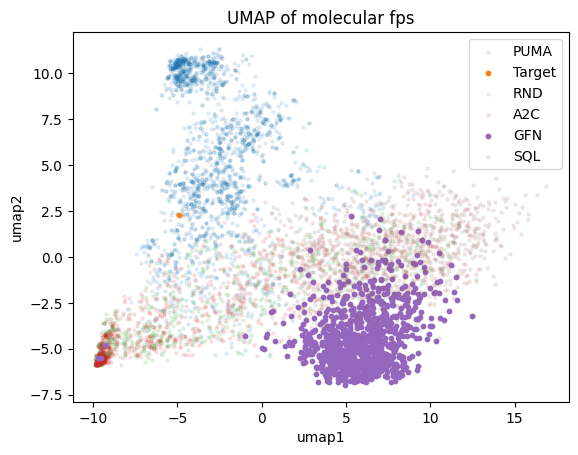

In [20]:
reducer = PCA(n_components=2)
# reducer = umap.UMAP(n_neighbors=10, random_state=42, verbose=True)
reducer = reducer.fit(all_fps)

for model_name, fp in fps.items():
    if len(fp) == 0:
        continue
    fp_reduced = reducer.transform(fp)
    if model_name in ["Target", "GFN"]:
        s = 10
        a = 1
    else:
        s = 5
        a = 0.1
    plt.scatter(fp_reduced[:, 0], fp_reduced[:, 1], label=model_name, alpha=a, s=s)

plt.legend()
plt.title("UMAP of molecular fps")
plt.xlabel("umap1")
plt.ylabel("umap2")
plt.show()

## Plot UMAP of struct latents generated by the GflowNet versus other models versus the background dataset

In [ ]:
rnd_idx = np.random.choice(len(datamodule.dataset), 2000, replace=False)
dataset_latents = [representations['struct'][i] for i in rnd_idx]

In [ ]:
latents = {
    'PUMA': dataset_latents,
    'Target': [representations['struct'][67]]
}

models = {
    "RND": "04-12-03-58-morph-sim-target-67-algo/swift-sweep-4-id-08lkh6fe",
    "A2C": "04-12-03-58-morph-sim-target-67-algo/jolly-sweep-3-id-4dj1ezru",
    "GFN": "04-12-03-58-morph-sim-target-67-algo/confused-sweep-1-id-qzlflioh",
    "SQL": "04-12-03-58-morph-sim-target-67-algo/absurd-sweep-2-id-6gjx9a58",
}

n_samples = 100
for model_name, run_id in models.items():
    run_dir = f"{base_dir}/{run_id}"
    trainer = load_trainer(run_dir)
    samples = sample_from_trained_model(run_dir, n_samples, n_samples, trainer)
    mols = [mol for mol, _ in samples]
    struct_latents = trainer.task.get_model_latents(mols)
    rewards = [reward.item() for _, reward in samples]
    struct_latents = [l for i, l in enumerate(struct_latents) if rewards[i] >= 0.9]
    latents[model_name] = [l for l in struct_latents]

# pca = PCA(n_components=2)
reducer = umap.UMAP(n_neighbors=20, random_state=42, verbose=True)
all_latents = []
for latent in latents.values():
    all_latents.extend(latent)

In [ ]:
reducer = reducer.fit(all_latents)

for model_name, latent in latents.items():
    if len(latent) == 0:
        continue
    latent_pca = reducer.transform(latent)
    if model_name == "Target":
        s = 10
    else:
        s = 5
    plt.scatter(latent_pca[:, 0], latent_pca[:, 1], label=model_name, alpha=0.5, s=s)

plt.legend()
plt.title("UMAP of struct latents")
plt.xlabel("umap1")
plt.ylabel("umap2")
plt.show()

## Plot UMAP of struct latents generated by the GflowNet during training versus other models during training

In [ ]:
import sqlite3
from collections import defaultdict

def sqlite_load(root, columns, num_workers=8, upto=None, begin=0):
    try:
        bar = tqdm(smoothing=0)
        values = defaultdict(lambda: [[] for i in range(num_workers)])
        for i in range(num_workers):
            con = sqlite3.connect(f'file:{root}generated_mols_{i}.db?mode=ro', uri=True, timeout=6)
            cur = con.cursor()
            cur.execute('pragma mmap_size = 134217728')
            cur.execute('pragma cache_size = -1024000;')
            r = cur.execute(f'select {",".join(columns)} from results where rowid >= {begin}')
            n = 0
            for j, row in enumerate(r):
                bar.update()
                for value, col_name in zip(row, columns):
                    values[col_name][i].append(value)
                n += 1
                if upto is not None and n * num_workers > upto:
                    break
            con.close()
        return values
    finally:
        bar.close()
        
sqlite_cols = ['smi', 'r'] + [f'{a}_{i}' for a in ['fr'] for i in range(1)] + ['ci_beta']

In [ ]:
rnd_idx = np.random.choice(len(datamodule.dataset), 2000, replace=False)
dataset_latents = [representations['struct'][i] for i in rnd_idx]

In [ ]:
latents = {
    'PUMA': dataset_latents,
    'Target': [representations['struct'][67]]
}

models = {
    "RND": "04-12-03-58-morph-sim-target-67-algo/swift-sweep-4-id-08lkh6fe",
    # "A2C": "04-12-03-58-morph-sim-target-67-algo/jolly-sweep-3-id-4dj1ezru",
    # "GFN": "04-12-03-58-morph-sim-target-67-algo/confused-sweep-1-id-qzlflioh",
    # "SQL": "04-12-03-58-morph-sim-target-67-algo/absurd-sweep-2-id-6gjx9a58",
}

n_samples = 100
for model_name, run_id in models.items():
    run_dir = f"{base_dir}/{run_id}"
    values = sqlite_load(f'{run_dir}/train/', sqlite_cols, 1)
    print(values)
    raise ValueError

    # trainer = load_trainer(run_dir)
    # samples = sample_from_trained_model(run_dir, n_samples, n_samples, trainer)
    # mols = [mol for mol, _ in samples]
    # struct_latents = trainer.task.get_model_latents(mols)
    # rewards = [reward.item() for _, reward in samples]
    # struct_latents = [l for i, l in enumerate(struct_latents) if rewards[i] >= 0.9]
    # latents[model_name] = [l for l in struct_latents]

# pca = PCA(n_components=2)
reducer = umap.UMAP(n_neighbors=20, random_state=42, verbose=True)
all_latents = []
for latent in latents.values():
    all_latents.extend(latent)